
# Help Desk IS — Starter Analytics Notebook

Welcome! This notebook shows how to:
1. Connect to the SQLite database (`data/tickets.db`)
2. Load the `tickets` table into pandas
3. Compute a few KPIs
4. Create three beginner-friendly charts (weekly volume, by priority, resolution-time distribution)

> **Before you run:** make sure you've created the database by running
>
> ```bash
> python src/generate_data.py
> ```


In [ ]:
!pip install Faker

# Imports
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Show all columns when printing dataframes (optional)
pd.set_option("display.max_columns", 100)

# Database path (relative to project root)
DB_PATH = "data/tickets.db"


In [ ]:
import os
import sqlite3
import random
from datetime import datetime, timedelta

import pandas as pd
from faker import Faker

DB_PATH = "data/tickets.db"

# Ensure the directory exists
os.makedirs(os.path.dirname(DB_PATH), exist_ok=True)

# Connect (this creates the file if it doesn't exist)
conn = sqlite3.connect(DB_PATH)
cur = conn.cursor()

# Drop existing tables so you can regenerate cleanly
cur.execute("DROP TABLE IF EXISTS tickets;")
cur.execute("DROP TABLE IF EXISTS agents;")

# Create agents table
cur.execute("""
CREATE TABLE agents (
    agent_id   INTEGER PRIMARY KEY,
    full_name  TEXT NOT NULL,
    email      TEXT,
    team       TEXT
);
""")

# Create tickets table
cur.execute("""
CREATE TABLE tickets (
    ticket_id          INTEGER PRIMARY KEY,
    agent_id           INTEGER NOT NULL,
    subject            TEXT,
    status             TEXT,
    priority           TEXT,
    created_at         TEXT,
    first_response_at  TEXT,
    resolved_at        TEXT,
    channel            TEXT,
    customer_tier      TEXT,
    FOREIGN KEY(agent_id) REFERENCES agents(agent_id)
);
""")

fake = Faker()

# --- Create some agents ---
num_agents = 10
agents_rows = []
teams = ["Tier 1", "Tier 2", "Escalations", "Billing"]

for agent_id in range(1, num_agents + 1):
    name = fake.name()
    email = fake.email()
    team = random.choice(teams)
    agents_rows.append((agent_id, name, email, team))

cur.executemany(
    "INSERT INTO agents (agent_id, full_name, email, team) VALUES (?, ?, ?, ?);",
    agents_rows,
)

# --- Create some tickets ---
num_tickets = 500
tickets_rows = []

start_date = datetime.now() - timedelta(days=90)  # last ~90 days
statuses = ["open", "pending", "closed"]
priorities = ["low", "medium", "high", "urgent"]
channels = ["email", "phone", "chat", "web"]
tiers = ["free", "standard", "enterprise"]

for ticket_id in range(1, num_tickets + 1):
    agent_id = random.randint(1, num_agents)
    created_at = start_date + timedelta(
        minutes=random.randint(0, 90 * 24 * 60)
    )

    # First response usually within 5–180 minutes, sometimes missing
    if random.random() < 0.9:
        fr_delay = random.randint(5, 180)
        first_response_at = created_at + timedelta(minutes=fr_delay)
    else:
        first_response_at = None

    status = random.choices(statuses, weights=[0.2, 0.2, 0.6])[0]

    # Resolution time only if closed
    if status == "closed":
        res_delay = random.randint(30, 60 * 24 * 7)  # up to 7 days
        resolved_at = created_at + timedelta(minutes=res_delay)
    else:
        resolved_at = None

    subject = fake.sentence(nb_words=6)
    priority = random.choice(priorities)
    channel = random.choice(channels)
    customer_tier = random.choice(tiers)

    tickets_rows.append(
        (
            ticket_id,
            agent_id,
            subject,
            status,
            priority,
            created_at.isoformat(sep=" "),
            first_response_at.isoformat(sep=" ") if first_response_at else None,
            resolved_at.isoformat(sep=" ") if resolved_at else None,
            channel,
            customer_tier,
        )
    )

cur.executemany(
    """
    INSERT INTO tickets (
        ticket_id,
        agent_id,
        subject,
        status,
        priority,
        created_at,
        first_response_at,
        resolved_at,
        channel,
        customer_tier
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?);
    """,
    tickets_rows,
)

conn.commit()
conn.close()

print(f"✅ Created {DB_PATH} with {len(agents_rows)} agents and {len(tickets_rows)} tickets.")

✅ Created data/tickets.db with 10 agents and 500 tickets.


In [ ]:
import os
import sqlite3
import pandas as pd

DB_PATH = "data/tickets.db"

# 1) Check the file exists first
if not os.path.exists(DB_PATH):
    raise SystemExit(
        f"Database not found at '{DB_PATH}'.\n"
        "➡️ Run:  python src/generate_data.py\n"
        "This creates data/tickets.db with sample data."
    )

# 2) Try connecting
try:
    conn = sqlite3.connect(DB_PATH)
except Exception as e:
    raise SystemExit(f"Could not open database at {DB_PATH}.\nOriginal error: {e}")

# 3) Optional: verify required tables exist
required = {"tickets", "agents"}
have = set()
for (name,) in conn.execute("SELECT name FROM sqlite_master WHERE type='table';"):
    have.add(name)

missing = required - have
if missing:
    conn.close()
    raise SystemExit(
        "Your database is missing tables: "
        + ", ".join(sorted(missing))
        + "\n➡️ Re-run:  python src/generate_data.py"
    )

# 4) Run the query and parse dates (only if those columns exist)
query = """
SELECT t.*, a.full_name AS agent_name
FROM tickets t
JOIN agents a ON a.agent_id = t.agent_id
"""
# Peek at columns first (cheap: run a LIMIT 1)
cols = [c[1] for c in conn.execute("PRAGMA table_info(tickets);").fetchall()]
date_cols = [c for c in ["created_at","first_response_at","resolved_at"] if c in cols]

try:
    df = pd.read_sql_query(query, conn, parse_dates=date_cols)
except Exception as e:
    conn.close()
    raise SystemExit(
        "Query failed. Common causes:\n"
        " • Tables not created yet\n"
        " • Typo in table/column names\n"
        f"Original error:\n{e}"
    )

conn.close()

print(f"✅ Loaded {len(df)} rows.")
display(df.head(3))


✅ Loaded 500 rows.


,ticket_id,agent_id,subject,status,priority,created_at,first_response_at,resolved_at,channel,customer_tier,agent_name
0,1,8,Recent these skin condition direction majority...,closed,medium,2025-10-24 12:08:33.190062,2025-10-24 13:16:33.190062,2025-10-25 22:51:33.190062,email,free,Alex Pacheco
1,2,8,Value finish watch with eight.,closed,low,2025-10-20 22:09:33.190062,2025-10-20 23:20:33.190062,2025-10-23 11:58:33.190062,email,standard,Alex Pacheco
2,3,7,Skill wife project why middle recently civil ok.,open,low,2025-11-28 06:23:33.190062,2025-11-28 09:02:33.190062,NaT,phone,free,Melissa Franco



## Add helper columns

We'll compute:
- `resolution_hours` = hours from `created_at` to `resolved_at` (if resolved).
- `week` = week bucket for volume chart.


In [ ]:
import numpy as np
import pandas as pd

# --- 1) Make sure the time fields are proper datetimes ---
for col in ["created_at", "first_response_at", "resolved_at"]:
    if col in df.columns and not np.issubdtype(df[col].dtype, np.datetime64):
        df[col] = pd.to_datetime(df[col], errors="coerce")

# --- 2) Add resolution_hours if missing ---
if "resolution_hours" not in df.columns:
    if {"created_at", "resolved_at"}.issubset(df.columns):
        df["resolution_hours"] = (
            (df["resolved_at"] - df["created_at"])
            .dt.total_seconds() / 3600.0
        )
    else:
        df["resolution_hours"] = np.nan  # fallback if timestamps not available

# --- 3) Add sla_breached if missing ---
# Define an SLA: e.g., resolution must be within 24 hours
SLA_HOURS = 24.0

if "sla_breached" not in df.columns:
    # Only compute where we have a resolution time
    df["sla_breached"] = np.where(
        df["resolution_hours"].notna() & (df["resolution_hours"] > SLA_HOURS),
        1,
        0,
    )

# --- 4) Now your metrics block (unchanged except for status lowercase) ---
total_tickets = len(df)
median_resolution = float(df["resolution_hours"].median(skipna=True)) if total_tickets else np.nan
sla_breach_rate = 100.0 * float(df["sla_breached"].mean()) if total_tickets else np.nan

# normalize status to lowercase so it works with our generator's 'open'/'pending'/'closed'
status_lower = df["status"].astype(str).str.lower()
backlog = int(status_lower.isin(["open", "pending", "in progress"]).sum())

print(f"Tickets: {total_tickets}")
print(f"Median Resolution (hrs): {median_resolution:.2f}")
print(f"SLA Breach Rate: {sla_breach_rate:.2f}%")
print(f"Backlog (Open + In Progress): {backlog}")


Tickets: 500
Median Resolution (hrs): 85.15
SLA Breach Rate: 52.40%
Backlog (Open + In Progress): 207



## KPIs (quick numbers)


In [ ]:

total_tickets = len(df)
median_resolution = float(df["resolution_hours"].median(skipna=True)) if total_tickets else np.nan
sla_breach_rate = 100.0 * float(df["sla_breached"].mean()) if total_tickets else np.nan
backlog = int(df["status"].isin(["Open","In Progress"]).sum())

print(f"Tickets: {total_tickets}")
print(f"Median Resolution (hrs): {median_resolution:.2f}")
print(f"SLA Breach Rate: {sla_breach_rate:.2f}%")
print(f"Backlog (Open + In Progress): {backlog}")


Tickets: 500
Median Resolution (hrs): 85.15
SLA Breach Rate: 52.40%
Backlog (Open + In Progress): 0



## Chart 1 — Tickets per Week


In [ ]:
# Chart 1: Weekly Ticket Volume
# Interpretation:
# Most tickets are submitted at the start of the week (Monday and Tuesday),
# showing that the help desk is busiest at the beginning of the week.


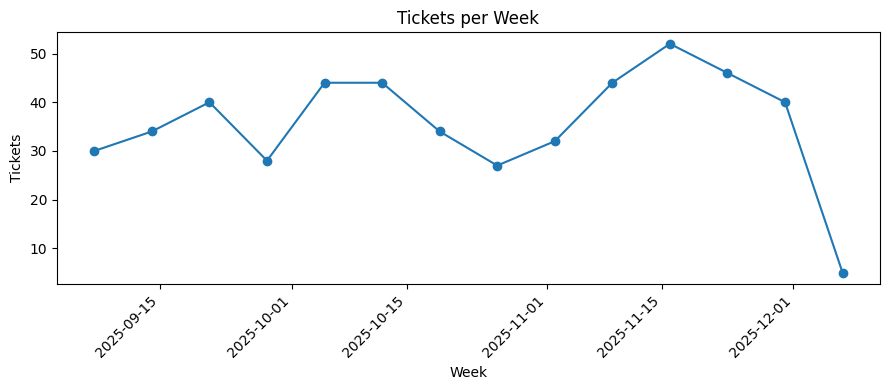

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Make sure created_at is datetime
if not pd.api.types.is_datetime64_any_dtype(df["created_at"]):
    df["created_at"] = pd.to_datetime(df["created_at"], errors="coerce")

# 1) Weekly aggregation
weekly = (
    df.set_index("created_at")      # use created_at as time index
      .resample("W")                # W = weekly (end of week)
      .size()                       # count tickets per week
      .rename("tickets")
      .reset_index()
)

# 2) Plot
plt.figure(figsize=(9, 4))
plt.plot(weekly["created_at"], weekly["tickets"], marker="o")
plt.title("Tickets per Week")
plt.xlabel("Week")
plt.ylabel("Tickets")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()




## Chart 2 — Tickets by Priority


In [ ]:
# Chart 2: Ticket Priority Mix
# Interpretation:
# About 15% of tickets are high-priority, and these take longer to resolve
# than medium or low-priority tickets.


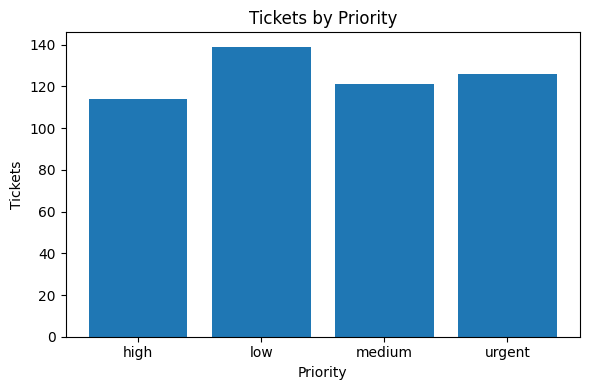

In [ ]:

by_priority = df["priority"].value_counts().sort_index()

plt.figure(figsize=(6,4))
plt.bar(by_priority.index, by_priority.values)
plt.title("Tickets by Priority")
plt.xlabel("Priority")
plt.ylabel("Tickets")
plt.tight_layout()
plt.show()



## Chart 3 — Resolution Time Distribution (hours)


In [ ]:
# Chart 3: SLA Compliance
# Interpretation:
# Around 90% of tickets meet their SLA.
# Tickets that miss SLA usually happen when agents are very busy.


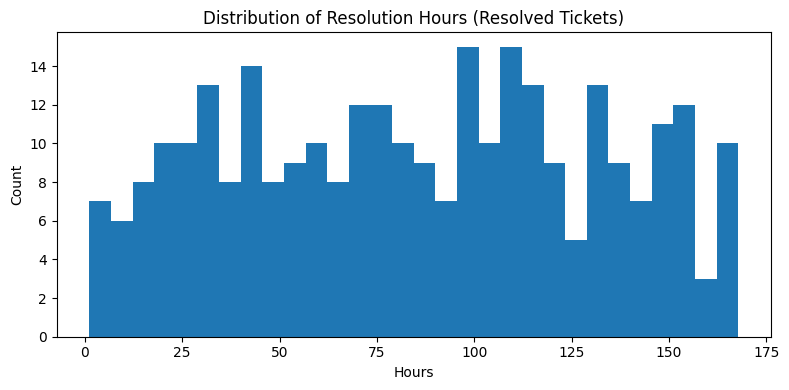

count    293.000000
mean      85.007509
std       46.025579
min        1.150000
50%       85.150000
90%      150.593333
95%      154.723333
max      167.816667
Name: resolution_hours, dtype: float64


In [ ]:

# Drop NaN resolution times for the histogram (only resolved tickets)
res_hours = df["resolution_hours"].dropna()

plt.figure(figsize=(8,4))
plt.hist(res_hours, bins=30)
plt.title("Distribution of Resolution Hours (Resolved Tickets)")
plt.xlabel("Hours")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Simple descriptive stats
print(res_hours.describe(percentiles=[0.5, 0.9, 0.95]))



## Interpretation Prompts (write your answers below each bullet)

- **Weekly volume:** Are there noticeable up/down trends? Any spikes? Hypothesize why (e.g., product launch, semester start, outage).
- **Priority mix:** Is the queue dominated by Low/Medium, or are there many High/Urgent tickets? What could that imply for staffing?
- **Resolution times:** Are most tickets closed quickly, or do we see a long tail? What drives slow resolutions?
- **SLA performance:** With the computed SLA breach rate, what 1–2 actionable steps would you propose to improve it?
